# Finding blobs in 64x64 images using conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils
import os.path

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data='/home/ubuntu/SAS_StemCell/'

In [15]:
def format_raw_image(img, shp):
    rtn=img
    slices=shp[0]
    width=shp[1]
    height=shp[2]
    channels=shp[3]
    frames=rtn.shape[0]/slices/width/height/channels
    frames=int(frames)
    rtn=rtn.reshape([frames, slices, channels, width, height])

    rtn=np.swapaxes(np.swapaxes(rtn,2,3),3,4)
    if (slices==1):
        rtn=rtn.reshape(frames, width, height, channels)
    if (channels==1):
        rtn=rtn.reshape(frames, slices, width, height)
    if (slices==1 and channels==1):
        rtn=rtn.reshape(frames, width, height)
    return rtn

#shp=[slices, width, height, channels]
def get_raw_float_image(fname, shp):
    rtn=np.fromfile(fname, np.float32)
    rtn=rtn.byteswap()
    rtn=format_raw_image(rtn,shp)
    return rtn

# Get data

Data reading function

In [16]:
shp=[1,64,64,4]

In [63]:
good_data=get_raw_float_image(data+'goodv2.tif_RotShift.raw', shp)[:,:,:,0:3]

In [91]:
bad_data=get_raw_float_image(data+'bad_subsetv2.raw', shp)[:,:,:,0:3]

In [92]:
tricky_data=get_raw_float_image(data+'Trickies_RotShift.raw', shp)[:,:,:,0:3]

Setup training set (training_*)

In [112]:
def get_data_and_truths(goods, bads, trickies):
    good_subset=good_data[goods,:,:,:]
    bad_subset=bad_data[bads, :,:,:]
    tricky_subset=tricky_data[trickies,:,:,:]
    my_list=np.concatenate((good_subset, bad_subset, tricky_subset), axis=0)
    my_truth=np.concatenate((np.ones([len(goods),1])*[1,0,0], np.ones([len(bads),1])*[0,0,1], np.ones([len(trickies),1])*[0,1,0]), axis=0)
    return (my_list, my_truth)

In [113]:
training_list,training_truth=get_data_and_truths(np.arange(0,55*201), np.arange(0,60000), np.arange(0,8000))

In [114]:
validation_list,validation_truth=get_data_and_truths(np.arange(55*201,65*201), np.arange(60000,67000), np.arange(8000,8500))

In [115]:
test_list,test_truth=get_data_and_truths(np.arange(65*201,70*201), np.arange(47000,49000), np.arange(8500,8800))

# Design network

In [97]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64,3])
y=tf.placeholder(dtype=tf.float32, shape=[None, 3])

base_scaler=8

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(x, base_scaler, [3,3], padding='SAME'))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

flattened=tf.layers.flatten(D2)
#I don't think this layer is actually necessary
#dense1=tf.layers.dropout(tf.layers.dense(flattened, 1024),0.5)
dense2=tf.layers.dense(flattened, 128)
dense3=tf.layers.dense(dense2, 16)
logits=tf.layers.dense(dense3, 3)

loss = tf.losses.softmax_cross_entropy(y, logits)

probs=tf.nn.softmax(logits)


train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)


# Training on easy set

In [116]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(20000):
    idx=np.random.choice(training_list.shape[0], replace=False, size=[2000])
    cur_train=training_list[idx,:,:,:]
    cur_truth=training_truth[idx,:]
    _,results, losses=sess.run([train_op, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%30==0):
        print(i)
        print("Training loss: ",losses)
        idx=np.random.choice(validation_list.shape[0], replace=False, size=[7000])
        sub_validation_data=validation_list[idx, :,:,:]
        sub_validation_truth=validation_truth[idx, :]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        print("Validation loss: ",losses)
        #f,axes=plt.subplots(2,2, figsize=(8,8))
        #ix=np.random.randint(0,100)
        #axes[0,0].imshow(sub_validation_data[ix,:,:,0])
        #axes[0,1].imshow(a[ix,:,:,1])
        #axes[1,0].imshow(a[ix,:,:,2])
        #axes[1,1].imshow(a[ix,:,:,3])
        #print([results[ix,0], sub_validation_truth[ix,0]])
        #plt.show()

0
Training loss:  5.9941626
Validation loss:  3.6037862
30
Training loss:  0.45686767
Validation loss:  0.59863144
60
Training loss:  0.18043627
Validation loss:  0.3431538
90
Training loss:  0.13461755
Validation loss:  0.2753965
120
Training loss:  0.088642694
Validation loss:  0.19758257
150
Training loss:  0.11503424
Validation loss:  0.1650455
180
Training loss:  0.077663064
Validation loss:  0.15409881
210
Training loss:  0.050006095
Validation loss:  0.15157191
240
Training loss:  0.050701965
Validation loss:  0.1188659
270
Training loss:  0.03322527
Validation loss:  0.09255967
300
Training loss:  0.028535632
Validation loss:  0.09614601
330
Training loss:  0.01991682
Validation loss:  0.0814861
360
Training loss:  0.0318074
Validation loss:  0.08193827
390
Training loss:  0.024987524
Validation loss:  0.07789393
420
Training loss:  0.02413494
Validation loss:  0.06523656
450
Training loss:  0.016161416
Validation loss:  0.059714723
480
Training loss:  0.021640824
Validation lo

KeyboardInterrupt: 

# Look at validation data

In [117]:
idx=np.random.choice(validation_list.shape[0], replace=False, size=[1000])
sub_validation_data=validation_list[idx, :,:,:]
sub_validation_truth=validation_truth[idx, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.027464464

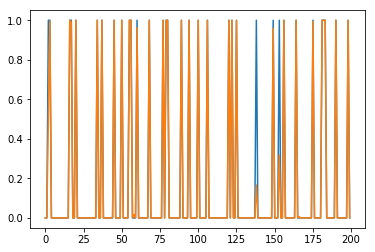

In [118]:
plt.plot(sub_validation_truth[0:200,0])
plt.plot(results[0:200,0])

In [119]:
bads=np.argwhere(np.round(results[:,0])!=sub_validation_truth[:,0])
bads

array([[138],
       [153],
       [452],
       [455],
       [529],
       [570],
       [713],
       [957],
       [979]])

[1.0, 0.16663629]


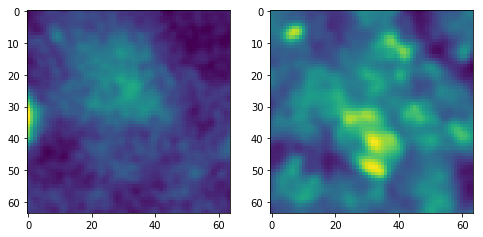

[1.0, 0.31752768]


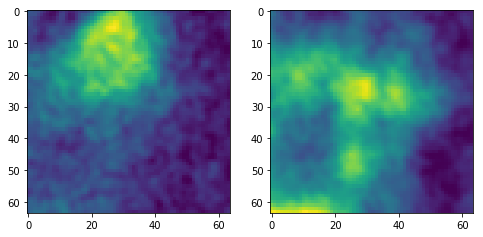

[1.0, 0.0012521591]


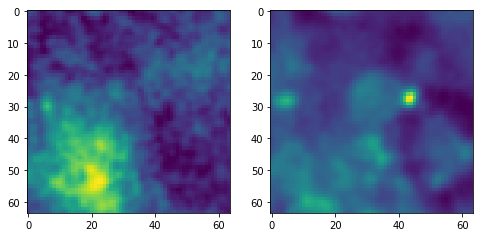

[1.0, 0.08485276]


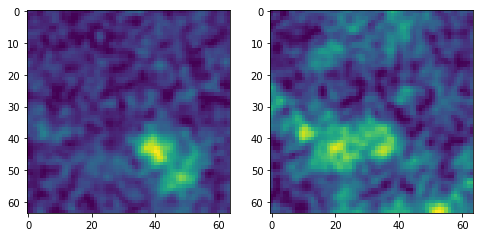

[1.0, 0.3611621]


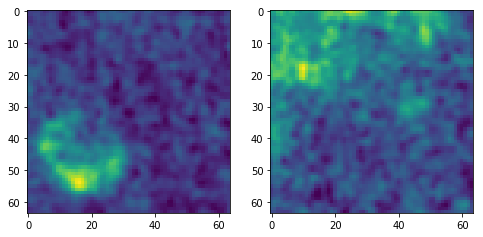

[1.0, 0.3609885]


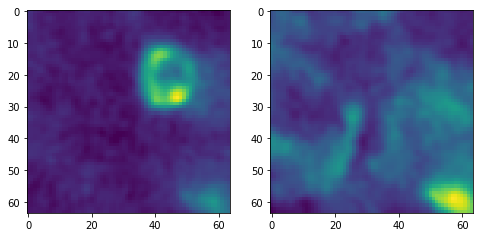

[0.0, 0.97508574]


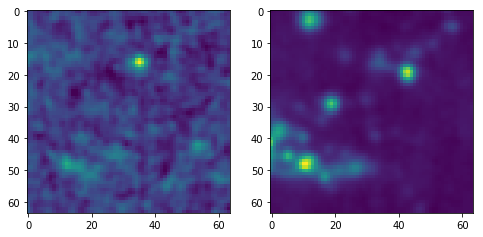

[1.0, 0.26479706]


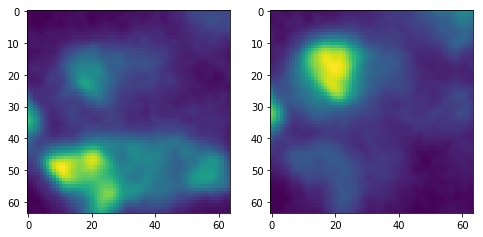

[1.0, 0.36745983]


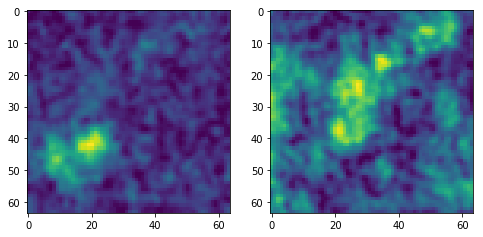

In [120]:
for i in bads:
    ix=i[0]
    f,axes=plt.subplots(1,2, figsize=(8,8))
    axes[0].imshow(sub_validation_data[ix,:,:,0])
    #axes[0,1].imshow(sub_validation_data[ix,:,:,1])
    axes[1].imshow(sub_validation_data[ix,:,:,2])
    #axes[1,1].imshow(sub_validation_data[ix,:,:,3])
    print([sub_validation_truth[ix,0], results[ix,0]])
    plt.show()

# Look at whole image bone 2 081516

In [77]:
sub_validation_data=true_test_data[0:8000, :,:,:]
sub_validation_truth=validation_truth[0:8000, :]
results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})

In [78]:
np.argwhere(np.round(results[:,0]))

array([[ 719],
       [ 720],
       [ 934],
       [ 935],
       [ 936],
       [ 937],
       [ 943],
       [ 944],
       [2238],
       [2239],
       [2664],
       [2665],
       [2666],
       [2669],
       [2670],
       [2671],
       [2672],
       [2673],
       [2674],
       [2675],
       [2676],
       [2677],
       [2678],
       [2679],
       [2680],
       [2887],
       [2888],
       [2893],
       [2894],
       [2895],
       [2896],
       [2897],
       [3096],
       [3098],
       [3099],
       [3105],
       [3528],
       [3529],
       [3530],
       [3531],
       [3532],
       [3533],
       [3534],
       [3535],
       [3536],
       [3537],
       [3538],
       [3539],
       [3540],
       [3541],
       [3738],
       [3747],
       [3748],
       [3749],
       [3755],
       [3756],
       [3757],
       [3758],
       [3836],
       [3837],
       [3838],
       [3839],
       [3964],
       [3965],
       [3966],
       [3967],
       [39

In [79]:
len(np.argwhere(np.round(results[:,0])))

89

[0.0, 0.9999411]

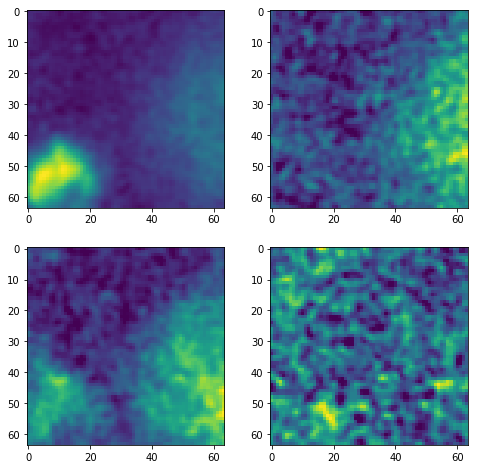

In [178]:
ix=888
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

# Look at whole image bone 2 13 081516

In [45]:
for s in range(3,7):
    curfile='test'+str(s)
    true_test2_data=get_raw_float_image(data+curfile+'.raw', shp)[:,:,:,0:3]
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,3])
    process_batch_size=8000
    print(curfile)
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        sub_validation_truth=validation_truth[0:sub_validation_data.shape[0], :]
        results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
        output[t:(t+process_batch_size)]=results[:,:]
    np.savetxt(data+curfile+'a.txt', output[:,0])
    np.savetxt(data+curfile+'b.txt', output[:,1])

test3
test4
test5
test6


In [121]:
true_test2_data=get_raw_float_image(data+'test6.raw', shp)[:,:,:,0:3]


In [122]:
num_images=true_test2_data.shape[0]
output=np.zeros(num_images)
process_batch_size=8000

In [123]:
for t in range(0,num_images,process_batch_size):
    endrng=np.min((t+process_batch_size,num_images))
    sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
    sub_validation_truth=validation_truth[0:sub_validation_data.shape[0], :]
    results, losses, a=sess.run([probs, loss, A1], feed_dict={x:sub_validation_data, y:sub_validation_truth})
    output[t:(t+process_batch_size)]=results[:,1]
np.sum(output>0.5)

813

In [186]:
np.savetxt('/home/ubuntu/SAS_StemCell/test6b.txt', output)

IndexError: index 7067 is out of bounds for axis 0 with size 821

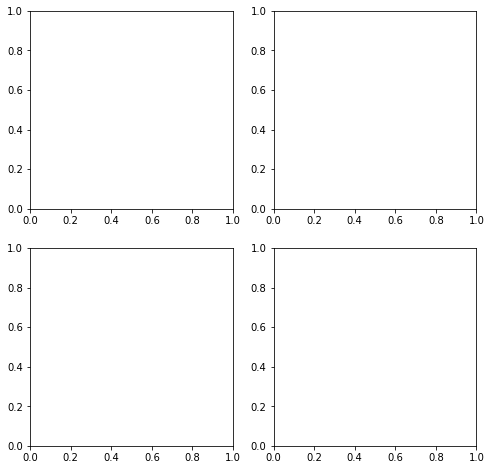

In [106]:
ix=7067
f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(sub_validation_data[ix,:,:,0])
axes[0,1].imshow(sub_validation_data[ix,:,:,1])
axes[1,0].imshow(sub_validation_data[ix,:,:,2])
axes[1,1].imshow(sub_validation_data[ix,:,:,3])
[sub_validation_truth[ix,0], results[ix,0]]

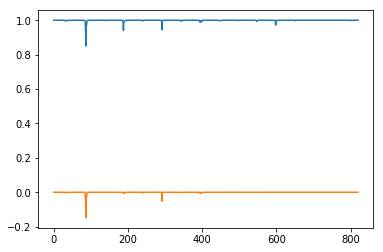

In [125]:
plt.plot(results[:,2]-0*results[:,1])
plt.plot(-results[:,1])



In [133]:
np.max(np.sum(results, axis=1))

1.0000001

In [145]:
saver=tf.train.Saver()

In [180]:
saver.save(sess, "/tmp/modelv2.ckpt")

'/tmp/modelv2.ckpt'